Statistical Theory - Final Project : Student Alcohol Consumption

Authors: Shilo Avital & Sarel Lieberman


In [75]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    accuracy_score,
    classification_report,
)
from sklearn.linear_model import LogisticRegression

In [76]:
# Plotting style
plt.rcParams.update(
    {
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "legend.fontsize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
    }
)

### 📊 Load Dataset: Student Alcohol Consumption

This function loads data from the **Kaggle Student Alcohol Consumption dataset**. It contains two CSV files:

- `student-mat.csv`: data related to students in a math course  
- `student-por.csv`: data related to students in a Portuguese language course

The datasets include attributes such as demographics, social and academic performance, and reported alcohol consumption.

The two datasets are concatenated vertically into a single DataFrame for unified analysis.


In [77]:
def load_data():
    math_df = pd.read_csv("data/student-mat.csv")
    por_df = pd.read_csv("data/student-por.csv")
    # concat dataframes vertically
    df = pd.concat([math_df, por_df], axis=0)
    return df

In [78]:
def save_figure(fig, filename: Path):
    """Save and close a matplotlib figure."""
    fig.tight_layout()
    fig.savefig(filename, bbox_inches="tight")
    plt.show()
    plt.close(fig)

In [79]:
Path("figures").mkdir(exist_ok=True)
df_copy = load_data()
fout = open("results_summary.txt", "w", encoding="utf-8")

### 📉 Q1: Relationship Between Weekend Alcohol Use and Final Grades

This section investigates the association between students' **weekend alcohol consumption (`Walc`)** and their **final grades (`G3`)** using two non-parametric statistical tests:

- **Spearman Correlation**:  
  Tests for a **monotonic** relationship between alcohol use and final grades, without assuming normality.  
  The test is one-sided (`alternative="less"`) to check whether **higher alcohol use tends to correspond to lower grades**.

- **Mann–Whitney U Test**:  
  Compares the distribution of `G3` between **frequent drinkers** (`Walc > 3`) and **non-frequent drinkers** (`Walc ≤ 3`), using a one-sided alternative hypothesis that frequent drinkers have **lower grades**.

#### Visualizations:
- A **boxplot** showing grade distribution across alcohol use levels.
- A **scatter plot with regression line** to visualize the trend between `Walc` and `G3`.

Results are interpreted at a significance level of **α = 0.05**.



Q1: Alcohol consumption vs grades
 Spearman r (Walc vs G3) = -0.149,  p = 6.286e-07
 Mann-Whitney U test: U-statistic = 68675.0000, p-value = 0.000000
Conclusion: Frequent drinkers (Walc > 3) have significantly lower G3 grades than non-frequent drinkers (Walc <= 3).


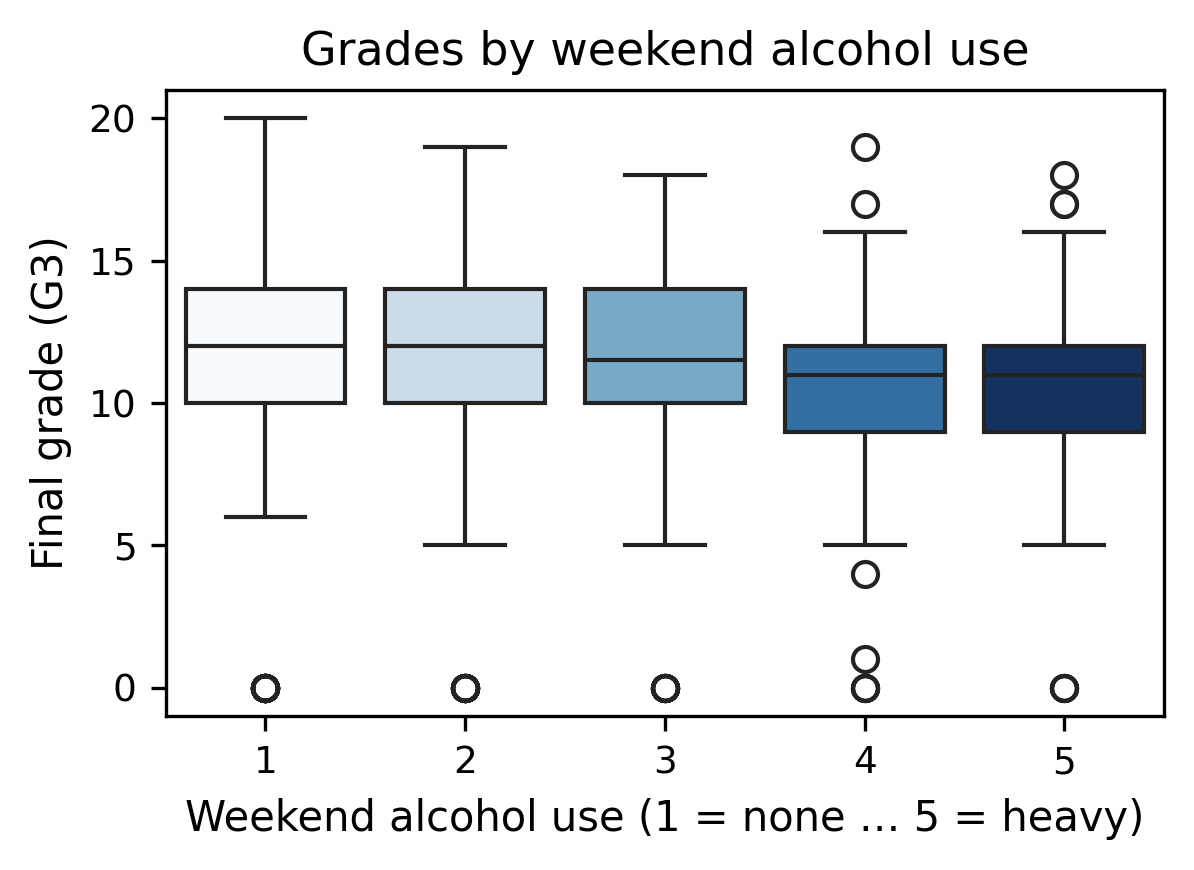

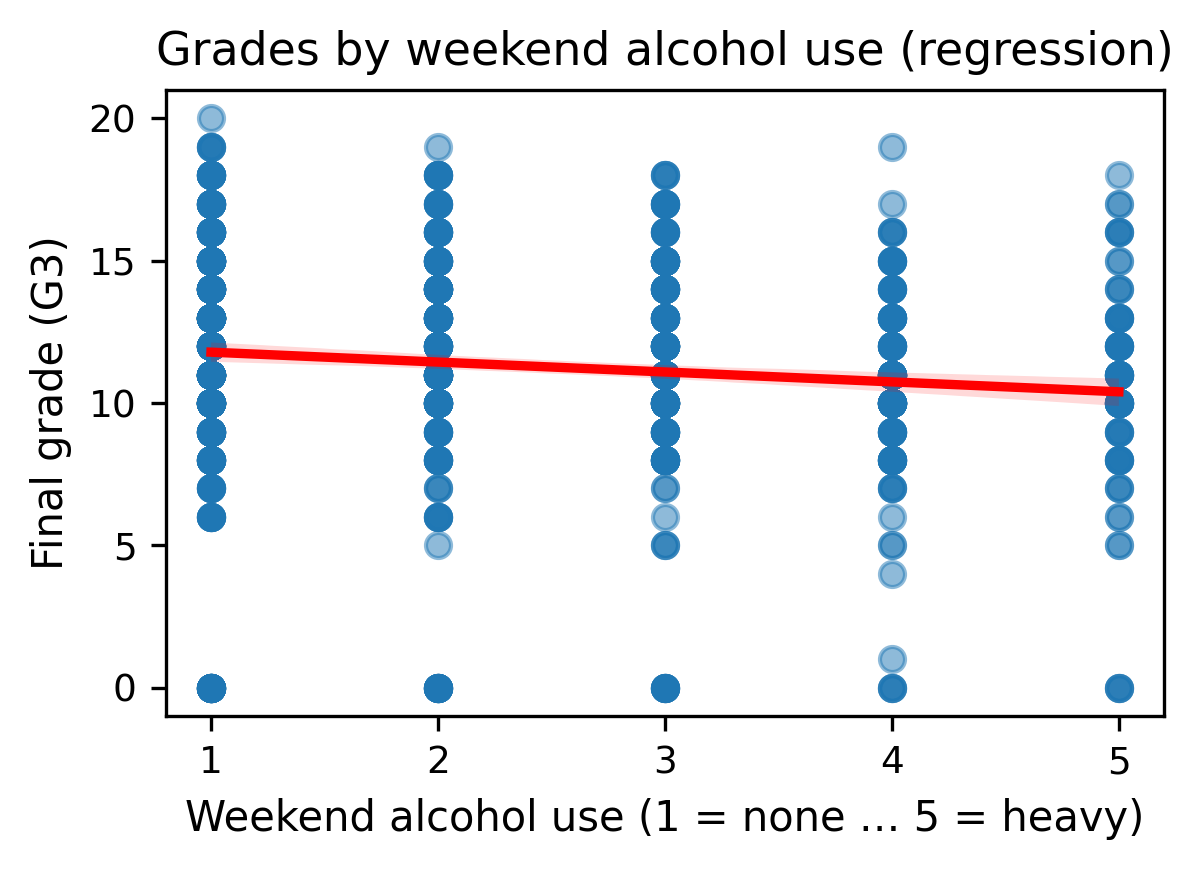

In [80]:
df = df_copy.copy()
msg = "Q1: Alcohol consumption vs grades"
fout.write(f"{msg}\n")
print(msg)

# Spearman correlation
r, p = stats.spearmanr(df["Walc"], df["G3"], alternative="less")
msg = f" Spearman r (Walc vs G3) = {r:.3f},  p = {p:.4g}"
fout.write(msg + "\n")
print(msg)


df["Walc"] = df["Walc"].astype(int)
frequent_drinkers = df[df["Walc"] > 3]["G3"]
non_frequent_drinkers = df[df["Walc"] <= 3]["G3"]
u_statistic, p_value = stats.mannwhitneyu(
    frequent_drinkers, non_frequent_drinkers, alternative="less"
)
msg = f" Mann-Whitney U test: U-statistic = {u_statistic:.4f}, p-value = {p_value:.6f}"
fout.write(msg + "\n")
print(msg)
if p_value < 0.05:
    # add to the conclusion the direction of the difference
    msg = "Conclusion: Frequent drinkers (Walc > 3) have significantly lower G3 grades than non-frequent drinkers (Walc <= 3)."
    fout.write(msg + "\n")
    print(msg)
else:
    msg = "Conclusion: No significant difference in G3 grades between frequent and non-frequent drinkers."
    fout.write(msg + "\n")
    print(msg)


fig, ax = plt.subplots(figsize=(4.2, 3))
sns.boxplot(data=df, x="Walc", y="G3", hue="Walc", palette="Blues", ax=ax, legend=False)
ax.set_xlabel("Weekend alcohol use (1 = none … 5 = heavy)")
ax.set_ylabel("Final grade (G3)")
ax.set_title("Grades by weekend alcohol use")
save_figure(fig, Path("figures/Q1_G3_Walc_boxplot.png"))

# plot a scatter plot with regression line for all the data
fig, ax = plt.subplots(figsize=(4.2, 3))
sns.regplot(
    data=df,
    x="Walc",
    y="G3",
    ax=ax,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
ax.set_xlabel("Weekend alcohol use (1 = none … 5 = heavy)")
ax.set_ylabel("Final grade (G3)")
ax.set_title("Grades by weekend alcohol use (regression)")
save_figure(fig, Path("figures/Q1_G3_Walc_regression.png"))

msg = f'{"-" * 80}'
fout.write(msg + "\n\n")
print()

### 🧪 Q2: Joint Test of Predictors on Weekend Alcohol Use

This section investigates whether a set of background variables jointly explain differences in students’ **weekend alcohol consumption (`Walc`)**, which is an **ordinal variable (1–5)**.

We use an **Ordinal Logistic Regression (Ordered Logit Model)** with the following predictors:

- `Fedu`: Father's education level  
- `Medu`: Mother's education level  
- `Pstatus`: Parental cohabitation status (mapped to binary)  
- `famsup`: Family educational support (yes/no → 1/0)  
- `romantic`: In a romantic relationship (yes/no → 1/0)

The joint hypothesis $ H_0: \beta_1 = \beta_2 = \cdots = \beta_5 = 0 $ is tested using a **Wald test**. This evaluates whether the set of predictors collectively contributes to modeling weekend alcohol use.

Output includes:
- χ² test statistic
- p-value
- Interpretation based on a 0.05 significance level


In [81]:
df = df_copy.copy()
msg = "Q2: Joint test of predictors on weekend alcohol use"
fout.write(f"{msg}\n")
print(msg)

df["Pstatus"] = df["Pstatus"].map({"T": 1, "A": 0})
df["famsup"] = df["famsup"].map({"yes": 1, "no": 0})
df["romantic"] = df["romantic"].map({"yes": 1, "no": 0})

X = df[["Fedu", "Medu", "Pstatus", "famsup", "romantic"]]
y = df["Walc"]

mod = OrderedModel(endog=y, exog=X, distr="logit")
res = mod.fit(method="bfgs", disp=False)

# 3. Build R for a joint test β1=…=β5=0
k_exog = X.shape[1]  # = 5
p_total = len(res.params)  # = 5 slopes + 4 thresholds = 9

R = np.zeros((k_exog, p_total))
for i in range(k_exog):
    R[i, i] = 1

wald_res = res.wald_test(R, scalar=True)

stat = float(wald_res.statistic)  # χ²
df_num = int(wald_res.df_denom)  # should be 5
pval = float(wald_res.pvalue)

msg = f"\nWald joint test of β1=…=β5=0\n  χ²({df_num}) = {stat:.3f}, p = {pval:.4f}"
fout.write(msg + "\n")
print(msg)
if pval < 0.05:
    msg = "→ Reject H₀: predictors jointly explain G3."
    fout.write(msg + "\n")
    print(msg)
else:
    msg = "→ Fail to reject H₀: no joint effect on G3 detected."
    fout.write(msg + "\n")
    print(msg)
msg = f'{"-" * 80}'
fout.write(msg + "\n\n")
print()

Q2: Joint test of predictors on weekend alcohol use

Wald joint test of β1=…=β5=0
  χ²(5) = 11.789, p = 0.0378
→ Reject H₀: predictors jointly explain G3.



### 🔍 Q3: Statistical Analysis of Predictors of Final Grades Among Heavy Drinkers

This section focuses on identifying predictors of final academic performance (`G3`) specifically among **heavy drinking students** (`Walc ≥ 4`).

The analysis combines two statistical methods for each predictor:

- **Kruskal–Wallis test**: a non-parametric test to detect differences in `G3` distributions across categories or levels of each predictor.
- **Spearman correlation**: a rank-based correlation measure to assess **monotonic relationships** between each predictor and final grade. It does not assume linearity or normality, making it suitable for ordinal or skewed data.

Predictors tested include parental education, relationship status, study habits, and school support.  
A **dual heatmap** visualizes the p-values from Kruskal–Wallis (top row) and Spearman correlations (bottom row) for each predictor, with boxes highlighted when both tests are significant (**p < 0.05**).

The results help isolate variables significantly associated with academic outcomes **within the high-risk group** of heavy drinkers.


Q3: Kruskal-Wallis test and Spearman Correlation for predictors on G3 (Heavy Drinkers)

Combined Kruskal & Spearman results:

Predictor Kruskal_stat Kruskal_p Spearman_r Spearman_p
 failures      47.3792    0.0000    -0.4671     0.0000
   higher      22.9168    0.0000     0.3303     0.0000
     Medu      14.4152    0.0061     0.2174     0.0015
     Fedu      12.2391    0.0066     0.2385     0.0005
    goout       6.6239    0.1571    -0.0954     0.1676
  Pstatus       1.9560    0.1619    -0.0965     0.1625
schoolsup       1.4503    0.2285    -0.0831     0.2293
 romantic       1.1291    0.2880    -0.0733     0.2890
   famsup       0.3050    0.5808    -0.0381     0.5820
 absences      17.4530    0.7379    -0.0936     0.1757
studytime       0.1850    0.9800     0.0091     0.8955


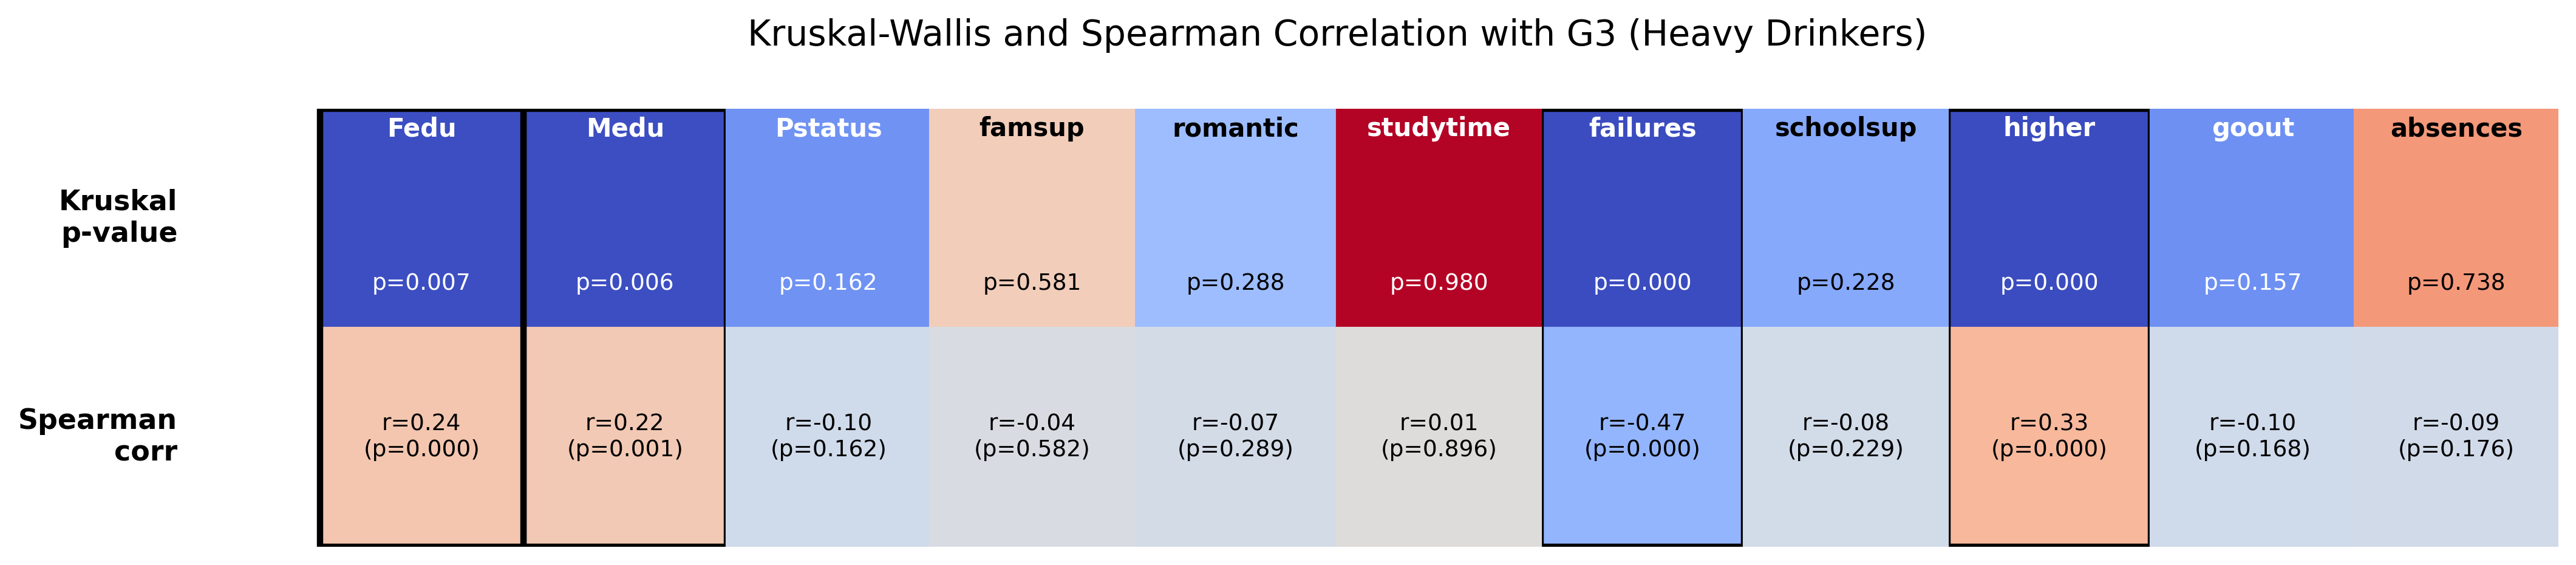

Significant predictors (p < 0.05 for both tests):

  failures: Kruskal p=0.000, Spearman r=-0.47
  higher: Kruskal p=0.000, Spearman r=0.33
  Medu: Kruskal p=0.006, Spearman r=0.22
  Fedu: Kruskal p=0.007, Spearman r=0.24



In [82]:
df = df_copy.copy()
msg = "Q3: Kruskal-Wallis test and Spearman Correlation for predictors on G3 (Heavy Drinkers)"
fout.write(f"{msg}\n")
print(msg)

# Encode categorical variables
df["Pstatus"] = df["Pstatus"].map({"T": 1, "A": 0})
df["famsup"] = df["famsup"].map({"yes": 1, "no": 0})
df["romantic"] = df["romantic"].map({"yes": 1, "no": 0})
df["schoolsup"] = df["schoolsup"].map({"yes": 1, "no": 0})
df["higher"] = df["higher"].map({"yes": 1, "no": 0})

# Filter for heavy drinkers
df = df[df["Walc"] >= 4]

predictors = [
    "Fedu",
    "Medu",
    "Pstatus",
    "famsup",
    "romantic",
    "studytime",
    "failures",
    "schoolsup",
    "higher",
    "goout",
    "absences",
]

# Collect Kruskal and Spearman results
results = []
for col in predictors:
    # Kruskal-Wallis test
    groups = [df[df[col] == val]["G3"] for val in df[col].dropna().unique()]
    kw_stat, kw_p = kruskal(*groups)

    # Spearman correlation
    r, p = stats.spearmanr(df["G3"], df[col])

    results.append(
        {
            "Predictor": col,
            "Kruskal_stat": kw_stat,
            "Kruskal_p": kw_p,
            "Spearman_r": r,
            "Spearman_p": p,
        }
    )

res_df = pd.DataFrame(results)
res_df.sort_values("Kruskal_p", inplace=True)

# Format float columns
res_df_formatted = res_df.copy()
float_cols = ["Kruskal_stat", "Kruskal_p", "Spearman_r", "Spearman_p"]
res_df_formatted[float_cols] = res_df_formatted[float_cols].map(
    lambda x: f"{x:.4f}"
)

# Save summary with formatting
msg = f"\nCombined Kruskal & Spearman results:\n"
fout.write(msg + "\n")
fout.write(res_df_formatted.to_string(index=False) + "\n\n")

print(msg)
print(res_df_formatted.to_string(index=False))

# -----------------------------------
# Plot: Dual-row heatmap
# -----------------------------------

# Normalize for color mapping (Kruskal p-values)
norm = plt.Normalize(res_df["Kruskal_p"].min(), res_df["Kruskal_p"].max())
colors = plt.cm.coolwarm(norm(res_df["Kruskal_p"]))


def get_contrasting_font_color(rgba_color):
    r, g, b = rgba_color[:3]
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return "black" if luminance > 0.6 else "white"


fig, ax = plt.subplots(figsize=(len(res_df) * 1.3, 3.2))

# --- Plot each column ---
for i, row in res_df.iterrows():
    pred = row["Predictor"]
    kw_p = row["Kruskal_p"]
    r = row["Spearman_r"]
    spearman_p = row["Spearman_p"]

    # --- Kruskal row (top) ---
    kw_color = plt.cm.coolwarm(norm(kw_p))
    ax.add_patch(plt.Rectangle((i, 1), 1, 1, color=kw_color))
    text_color_kw = get_contrasting_font_color(kw_color)
    ax.text(i + 0.5, 1.25, f"p={kw_p:.3f}", ha="center", va="top", fontsize=9, color=text_color_kw)

    # --- Spearman row (bottom) ---
    spearman_color = plt.cm.coolwarm((r + 1) / 2)
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=spearman_color))
    text_color_r = get_contrasting_font_color(spearman_color)
    ax.text(
        i + 0.5,
        0.5,
        f"r={r:.2f}\n(p={spearman_p:.3f})",
        ha="center",
        va="center",
        fontsize=9,
        color=text_color_r,
    )
    ax.text(
        i + 0.5,
        1.85,
        pred,
        ha="center",
        va="bottom",
        fontsize=10,
        weight="bold",
        color=get_contrasting_font_color(kw_color),
    )

    # --- Highlight box if both p-values < 0.05 ---
    if kw_p < 0.05 and spearman_p < 0.05:
        ax.add_patch(
            plt.Rectangle((i, 0), 1, 2, fill=False, edgecolor="black", linewidth=2.5)
        )

# --- Row labels ---
ax.text(
    -0.7, 1.5, "Kruskal\np-value", ha="right", va="center", fontsize=11, weight="bold"
)
ax.text(-0.7, 0.5, "Spearman\ncorr", ha="right", va="center", fontsize=11, weight="bold")

# --- Formatting ---
ax.set_xlim(-1, len(res_df))
ax.set_ylim(0, 2)
ax.axis("off")


plt.title(
    "Kruskal-Wallis and Spearman Correlation with G3 (Heavy Drinkers)",
    fontsize=14,
    pad=25,
)

save_figure(fig, Path("figures/Q3_Kruskal_and_Correlation.png"))

# print what predictors were significant
significant_predictors = res_df[(res_df["Kruskal_p"] < 0.05) & (res_df["Spearman_p"] < 0.05)]
if not significant_predictors.empty:
    msg = "Significant predictors (p < 0.05 for both tests):\n"
    fout.write(msg + "\n")
    print(msg)
    for _, row in significant_predictors.iterrows():
        msg = f"  {row['Predictor']}: Kruskal p={row['Kruskal_p']:.3f}, Spearman r={row['Spearman_r']:.2f}"
        fout.write(msg + "\n")
        print(msg)
else:
    msg = "No predictors were significant (p < 0.05) for both tests."
    fout.write(msg + "\n")
    print(msg)

# Final separator
fout.write(f"{'-'*80}\n\n")
print()

### 🧮 Q4: Predicting Student Failure Using Logistic Regression

In this task, we build a **binary classifier** to predict whether a student is likely to **fail** (defined as `G3 < 11`) based on academic, behavioral, and social predictors.

#### Steps:
1. **Feature Engineering**: Convert categorical variables (`famsup`, `schoolsup`, `romantic`, `higher`) to binary.
2. **Predictors**: Include variables like alcohol use (`Walc`), absences, parental education, study time, social behavior (`goout`, `romantic`), and support systems.
3. **Modeling**: A pipeline combining `StandardScaler` and `LogisticRegression` is trained on an 80/20 train/test split.
4. **Evaluation Metrics**:
   - **AUC (Area Under ROC Curve)**
   - **Accuracy**
   - **Confusion Matrix**
   - **Precision / Recall / F1-score** (via classification report)
5. **Visualization**: The ROC curve is plotted to assess model discrimination ability.

This model offers insight into risk factors associated with academic failure and demonstrates how logistic regression can be applied to educational datasets.


Q4: Predicting student failure using logistic regression

AUC: 0.846
Accuracy: 0.770
Confusion matrix:
[[118  14]
 [ 34  43]]

Classification report:
              precision    recall  f1-score   support

           0      0.776     0.894     0.831       132
           1      0.754     0.558     0.642        77

    accuracy                          0.770       209
   macro avg      0.765     0.726     0.736       209
weighted avg      0.768     0.770     0.761       209



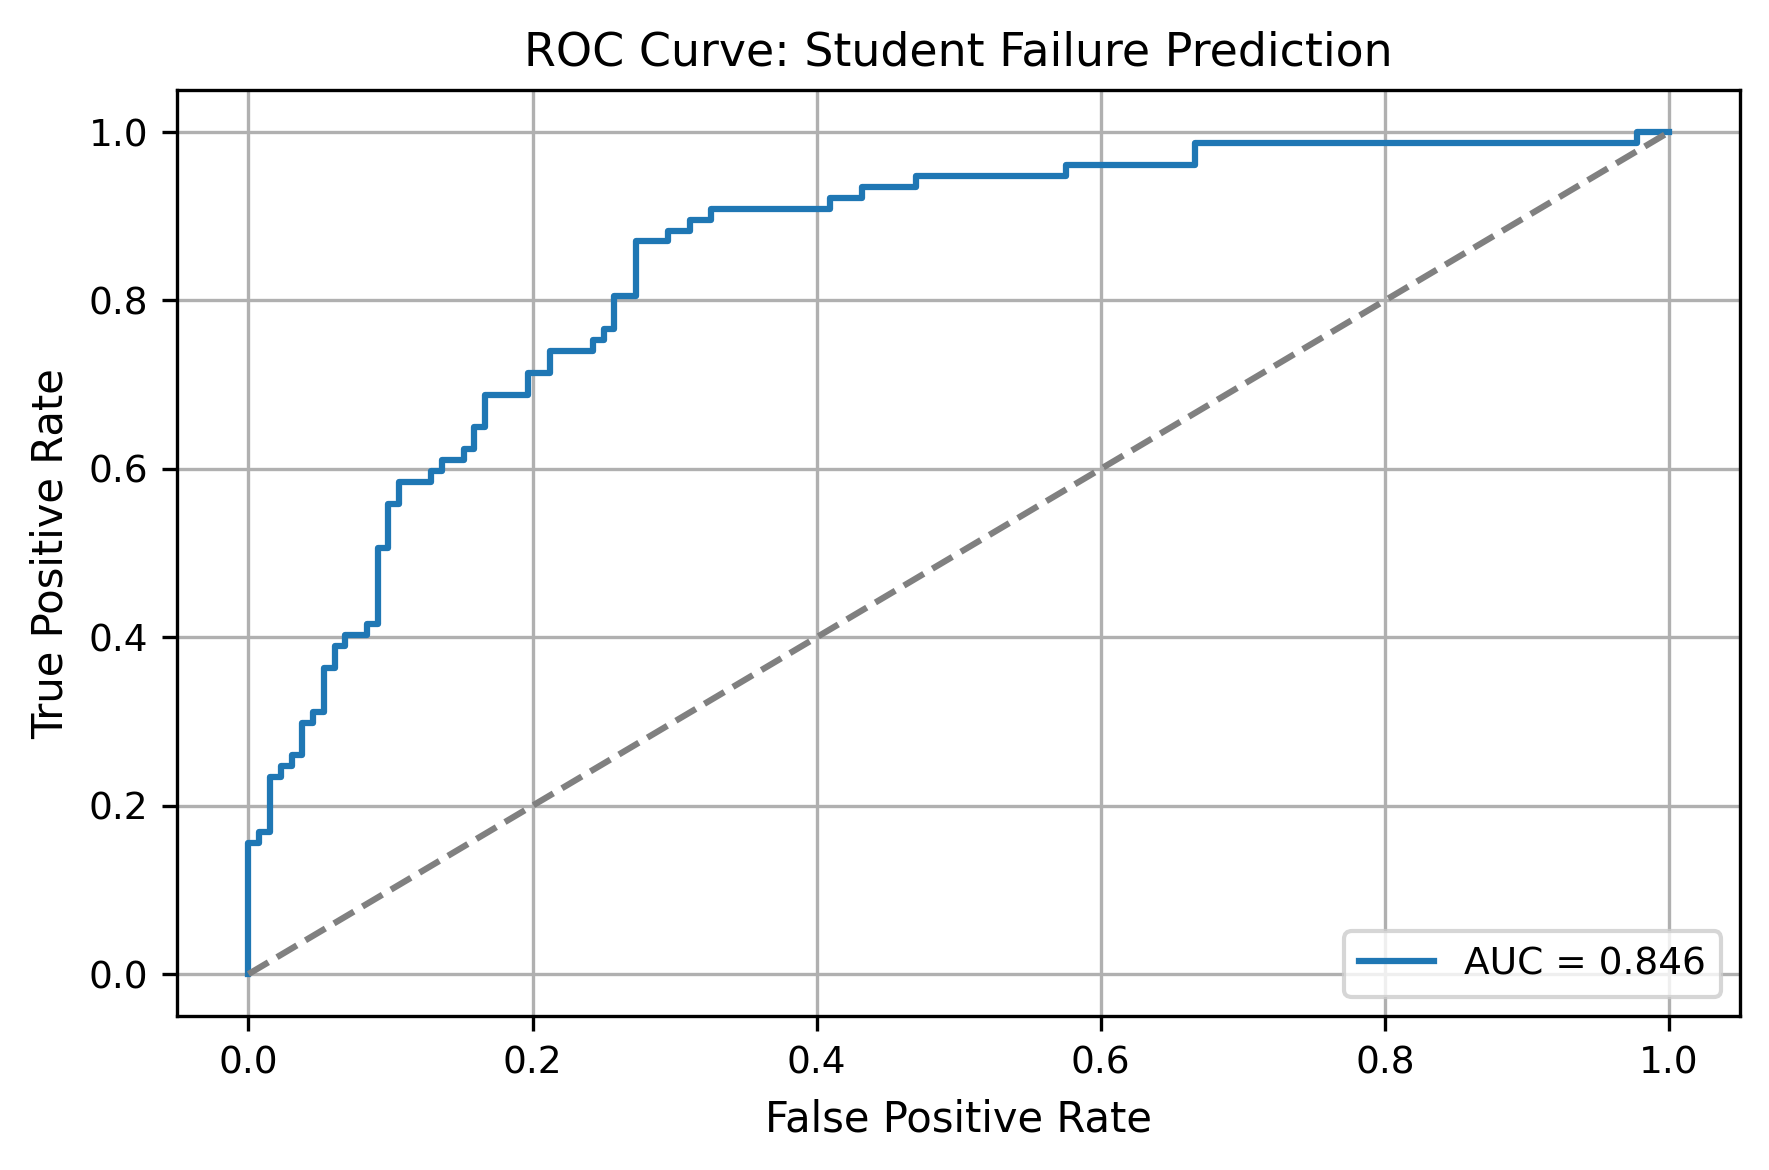

In [83]:
df = df_copy.copy()

msg = "Q4: Predicting student failure using logistic regression"
fout.write(f"{msg}\n")
print(msg)


# 2. Feature engineering
binary_map = {"yes": 1, "no": 0}
for col in ["famsup", "schoolsup", "romantic", "higher"]:
    df[col] = df[col].map(binary_map)

# Predictors and target
PREDICTORS = [
    "Walc",
    "absences",
    "studytime",
    "failures",
    "famsup",
    "schoolsup",
    "health",
    "romantic",
    "higher",
    "goout",
    "Fedu",
    "Medu",
]
X = df[PREDICTORS]
y = (df["G3"] < 11).astype(int)  # 1=fail, 0=pass

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=269, stratify=y
)

# 4. Pipeline: scale + logistic regression
pipe = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=10000, solver="lbfgs")
)
pipe.fit(X_train, y_train)

# 5. Predictions & metrics
y_prob = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

msg = (
    f"\nAUC: {auc:.3f}\n"
    f"Accuracy: {acc:.3f}\n"
    f"Confusion matrix:\n{cm}\n\n"
    f"Classification report:\n{report}"
)
fout.write(msg)
print(msg)


# 6. Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Student Failure Prediction")
plt.legend(loc="lower right")
plt.grid(True)
save_figure(plt.gcf(), Path("figures/Q4_ROC_curve.png"))

In [84]:
fout.close()